In [18]:
# Suba o arquivo kaggle.json, que contém suas credenciais
from google.colab import files
files.upload()

# Criar pasta .kaggle e mover kaggle.json para ela
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Definir permissões para o arquivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [21]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chest_xray/__MACOSX/._chest_xray  
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
replace chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [22]:
!pip install lime opencv-python matplotlib scikit-learn seaborn

In [23]:
#bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf # Import tensorflow
from tensorflow.keras.models import Sequential # Use tensorflow.keras.models for Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization # Use tensorflow.keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras.preprocessing.image for ImageDataGenerator
#from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau # Use tensorflow.keras.callbacks for ReduceLROnPlateau
import cv2
import os

In [24]:
import numpy as np
import os
import cv2

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # 0 para 'PNEUMONIA', 1 para 'NORMAL'
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Redimensionar imagens
                data.append([resized_arr, class_num])  # Adicionar imagem e rótulo à lista
            except Exception as e:
                print(e)
    return data

In [25]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

<Axes: xlabel='count'>

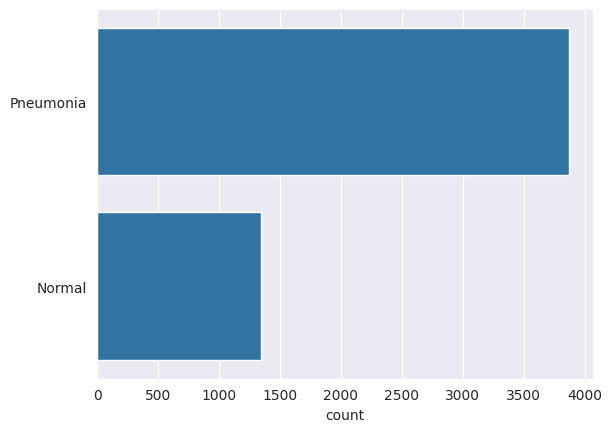

In [26]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

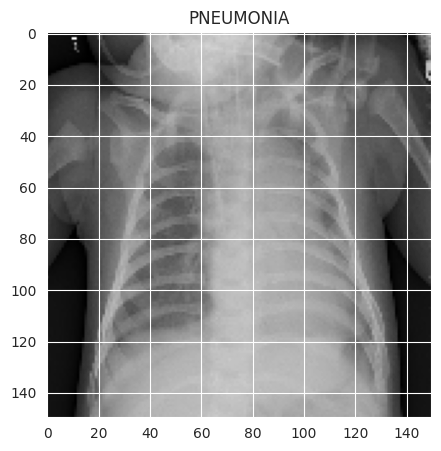

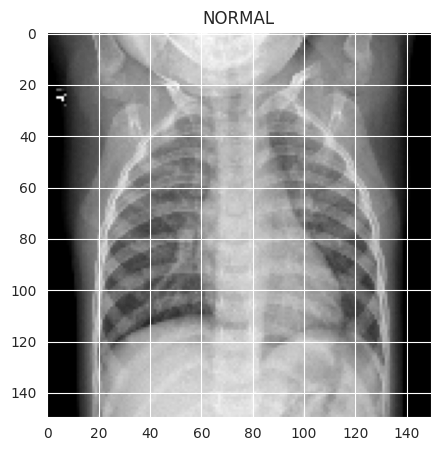

In [27]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [28]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [29]:
# Normalizar os dados para melhorar convergência
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [30]:
# resize imagens para aprendizado profundo
x_train = x_train.reshape(-1, img_size, img_size, 1) # (Número de amostras, Altura, Largura, Canais)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [31]:
# Data Augmentation para prevenir overfitting e manipular dados desbalanceados

datagen = ImageDataGenerator(
        rotation_range = 30,  # rotação
        zoom_range = 0.2, # Zoom
        width_shift_range=0.1,  # desloca aleatoriamente as imagens horizontalmente (fração da largura total)
        height_shift_range=0.1,  # desloca verticalmente
        horizontal_flip = True,  # flipa as imagens horizontalmente
        vertical_flip=False)  # flipa as imagens verticalmenter


datagen.fit(x_train)

Camadas da CNN:

strides=1: Define o passo de movimentação do filtro (1 pixel de cada vez).
padding='same': A camada adiciona zeros ao redor da imagem para garantir que a saída tenha o mesmo tamanho que a entrada.
activation='relu': Aplica a função de ativação ReLU (Rectified Linear Unit), que transforma os valores negativos em zero.
input_shape=(150,150,1): Define a forma da entrada da rede como imagens de tamanho 150x150 com 1 canal (imagens em escala de cinza).

In [32]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization()) #Adiciona uma camada de normalização em lote (Batch Normalization), que normaliza as ativações da camada anterior durante o treinamento, ajudando a estabilizar e acelerar o treinamento.
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same')) #Adiciona uma camada de Pooling Max 2D que reduz a dimensão da entrada.
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten()) #Flatten: Esta camada achata a saída da última camada convolucional (que é 3D) em uma matriz 1D, preparando a entrada para as camadas totalmente conectadas (densas).
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid')) #Adiciona uma última camada densa com 1 neurônio. Essa é a camada de saída, usada para classificação binária (pneumonia ou normal).
#activation='sigmoid': A função de ativação sigmoide é apropriada para problemas de classificação binária, retornando um valor entre 0 e 1.
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# O otimizador RMSProp é usado para ajustar os pesos do modelo. loss='binary_crossentropy': A função de perda usada para problemas de classificação binária.
#metrics=['accuracy']: Métrica usada para monitorar o desempenho do modelo, aqui a acurácia.
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

A função abaixo usa a callback ReduceLROnPlateau da biblioteca Keras/TensorFlow. Essa callback é utilizada para ajustar automaticamente a taxa de aprendizado (learning rate) durante o treinamento do modelo. Vamos detalhar o que cada argumento faz:

ReduceLROnPlateau: É uma callback que monitora uma métrica (no caso, a val_accuracy) e reduz a taxa de aprendizado quando essa métrica parar de melhorar.

monitor='val_accuracy': Esse parâmetro indica qual métrica o ReduceLROnPlateau deve monitorar. Neste caso, está monitorando a acurácia do conjunto de validação (val_accuracy). Ou seja, se a acurácia de validação não melhorar por um número de épocas consecutivas, a taxa de aprendizado será reduzida.

patience=2: Define o número de épocas (sem melhora na métrica monitorada) antes de reduzir a taxa de aprendizado. Neste caso, se a acurácia de validação não melhorar após 2 épocas consecutivas, o learning rate será reduzido.

verbose=1: Este parâmetro define o nível de verbosidade. Quando verbose=1, o Keras imprimirá uma mensagem sempre que a taxa de aprendizado for reduzida, informando o novo valor.

factor=0.3: Esse é o fator multiplicador pelo qual a taxa de aprendizado será reduzida. Quando a condição de paciência for atendida, a taxa de aprendizado será multiplicada por 0.3 (ou seja, será reduzida para 30% do valor atual).

min_lr=0.000001: Define o valor mínimo da taxa de aprendizado. A taxa de aprendizado nunca será reduzida para um valor abaixo de 0.000001 (1e-6), evitando que o modelo "pare" de aprender completamente.

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [34]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8102 - loss: 1.1500 - val_accuracy: 0.5000 - val_loss: 26.0834 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8964 - loss: 0.2928 - val_accuracy: 0.5000 - val_loss: 55.2835 - learning_rate: 0.0010
Epoch 3/12
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9150 - loss: 0.2189
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9150 - loss: 0.2190 - val_accuracy: 0.5000 - val_loss: 17.3187 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.9426 - loss: 0.1518 - val_accuracy: 0.5000 - val_loss: 29.0183 - learning_rate: 3.0000e-04
Epoch 5/12
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9470 - loss: 0.1437
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9471 - loss: 0.

In [35]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8808 - loss: 0.2869
Loss of the model is -  0.28015586733818054
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8808 - loss: 0.2869
Accuracy of the model is -  88.62179517745972 %


In [36]:
predictions = (model.predict(x_test) > 0.5).astype("int32") # converte as previsões em valores binários. >0.5 é de uma classe e <0.5 de outra classe.
predictions = predictions.reshape(1,-1)[0] #Ajusta o formato do array para um vetor de uma única dimensão.
predictions[:15] #imprimi as 15 primeiras previsões.

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [37]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.87      0.91       390
   Normal (Class 1)       0.81      0.91      0.86       234

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.88       624
       weighted avg       0.89      0.89      0.89       624



In [38]:
cm = confusion_matrix(y_test,predictions)
cm

array([[340,  50],
       [ 21, 213]])

In [39]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

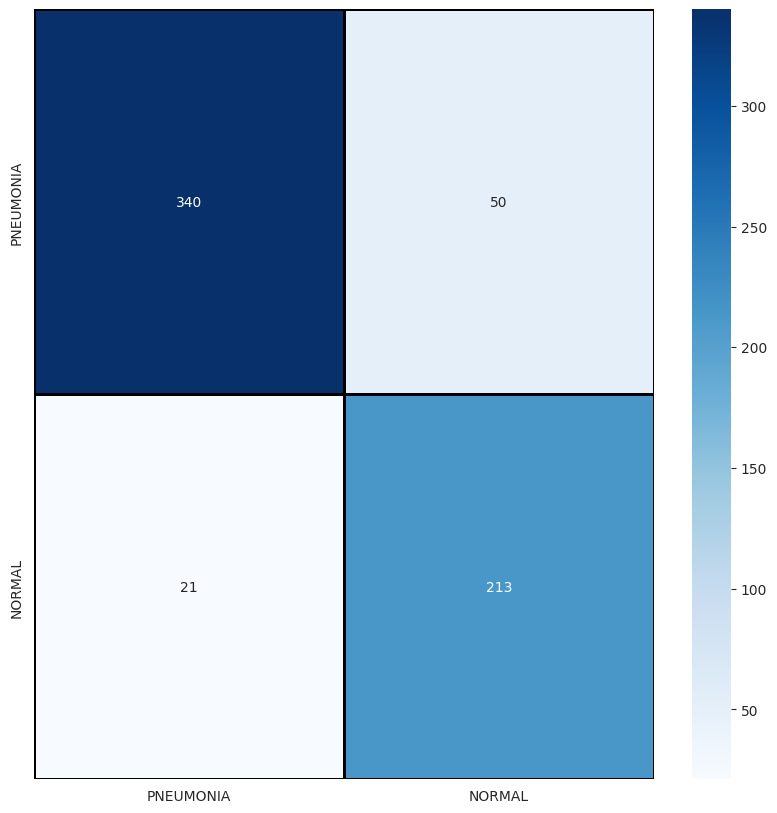

In [40]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.show();

In [41]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

Abaixo estão as predições corretas!

<ipython-input-42-c797c45d81b2>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


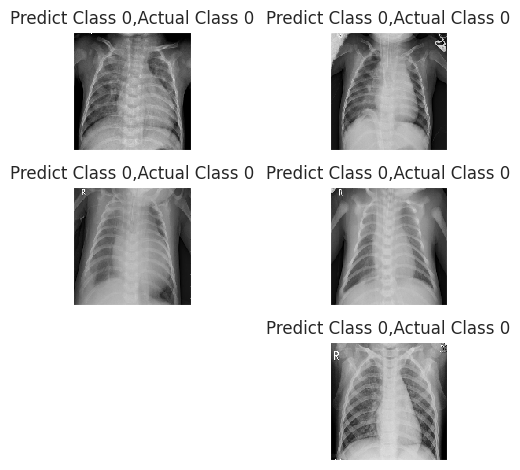

In [42]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predict Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

0 para 'PNEUMONIA', 1 para 'NORMAL'

Abaixo estão as predições erradas!

<ipython-input-43-74bacaa659b4>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


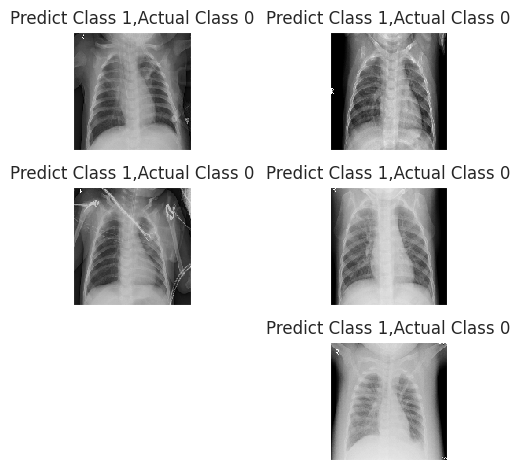

In [43]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predict Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Pegue a primeira imagem do x_train (garantindo que acessamos a imagem e não o rótulo)
img = np.array(train[0][0]) #imagem com pneumonia

# Redimensione para garantir o formato correto (1, img_size, img_size, 1) para uma imagem de entrada
img = img.reshape(1, img_size, img_size, 1)


# Certifique-se de que o modelo tenha sido "chamado" para inicializar as camadas
_ = model.predict(img)  # Chamar o modelo pelo menos uma vez com um exemplo de entrada

# Crie um novo modelo que retorna as saídas de todas as camadas
layer_outputs = [layer.output for layer in model.layers]  # Pegue as saídas de todas as camadas
print(layer_outputs[0])
activation_model= tf.keras.models.Model([model.inputs], [model.get_layer('conv2d_15').output]) #modifique o nome da camada aqui!! Veja os nomes em model.summary()


# Obtenha as ativações para a imagem selecionada
activations = activation_model.predict(img)

# Função para visualizar as ativações de uma camada específica
def display_activations(activations, col_size, row_size, layer_number):
    activation = activations[layer_number]  # Ativações da camada escolhida
    num_filters = activation.shape[-1]  # Número de filtros na camada
    fig, ax = plt.subplots(row_size, col_size, figsize=(15, 15))
    activation_index = 0

    for row in range(0, row_size):
        for col in range(0, col_size):
            if activation_index < num_filters:
                #ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
                ax[row][col].imshow(activation[:, :, activation_index], cmap='gray')
                activation_index += 1
            ax[row][col].axis('off')  # Desabilitar eixos para melhor visualização

    plt.show()

# Visualizando as ativações da primeira camada convolucional
display_activations(activations, 8, 8, layer_number=0)  # Camada 0 (primeira convolucional)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
<KerasTensor shape=(None, 150, 150, 32), dtype=float32, sparse=False, name=keras_tensor_255>


ValueError: No such layer: conv2d_15. Existing layers are: ['conv2d_5', 'batch_normalization_5', 'max_pooling2d_5', 'conv2d_6', 'dropout_4', 'batch_normalization_6', 'max_pooling2d_6', 'conv2d_7', 'batch_normalization_7', 'max_pooling2d_7', 'conv2d_8', 'dropout_5', 'batch_normalization_8', 'max_pooling2d_8', 'conv2d_9', 'dropout_6', 'batch_normalization_9', 'max_pooling2d_9', 'flatten_1', 'dense_2', 'dropout_7', 'dense_3'].